# Key words exploration

The objective of this section is to explore reviews in an attempt to find common needs for travellers with special needs
The procedure is as follows:
1. For each category, perform TF-IDF to identify the most symbolic words in the reviews
2. To better identify discriminatory words, remove some of the common words using a ratio system

In [56]:
import polars as pl
import torch
torch.set_num_threads(4)
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from tqdm import tqdm
import spacy
from typing import List
from stop_words import get_stop_words
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF


## Retrieve reviews related to special needs

After compiling relevant datasets, the cleaned reviews must be retrieved to perform statistical analysis.

### Load reviews cleaned

In [3]:
def process_category(category_name: str, df_kw_path: str, df_final_path_template: str, output_path_template: str):
    """
    Process reviews for a given category:
    - load the final reviews
    - join with keywords
    - rename the cleaned review column
    - filter by category
    - write to CSV
    """
    # Load final reviews
    df_final = pl.read_csv(df_final_path_template.format(category=category_name))
    
    # Load keywords
    df_kw = pl.read_csv(df_kw_path)
    
    # Join on id
    df = df_final.join(df_kw, left_on="id", right_on="id", how="left")
    
    # Rename column
    df = df.rename({"review_right": "review_cleaned"})
    
    # Filter by category
    df = df.filter(pl.col("category") == category_name)
    
    # Write CSV
    df.write_csv(output_path_template.format(category=category_name))
    print(f"Processed category '{category_name}' -> {output_path_template.format(category=category_name)}")

# Paramètres
categories = ["child", "pet", "handicap"]
df_kw_path = "../../data/processed/Bazarre/key_words_data_hotel_reviews_1.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_hotel_reviews_1_{category}_good.csv"
output_path_template = "test_{category}.csv"

# Exécution
for cat in categories:
    process_category(cat, df_kw_path, df_final_path_template, output_path_template)


Processed category 'child' -> test_child.csv
Processed category 'pet' -> test_pet.csv
Processed category 'handicap' -> test_handicap.csv


### Merge all the categories in one csv

In [4]:
csv_files = [
    "test_child.csv",
    "test_pet.csv",
    "test_handicap.csv"
]

df_list = [pl.read_csv(f) for f in csv_files]
df = pl.concat(df_list)

print(f"Merged {len(csv_files)} CSV files into a single DataFrame with {df.shape[0]} rows.")

Merged 3 CSV files into a single DataFrame with 200 rows.


### Lemmatization of reviews

Statistical methods are based on word occurrence. To improve the robustness and consistency of the results, a lemmatization step of our reviews can/should be applied.

In [5]:
# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


def lemmatize_and_clean_texts(
    texts: List[str],
    batch_size: int = 2000,
    n_process: int = 4
) -> List[str]:
    clean_texts = [(t if isinstance(t, str) else "") for t in texts]
    lemmatized = []
    for doc in nlp.pipe(clean_texts, batch_size=batch_size, n_process=n_process):
        text = " ".join([token.lemma_ for token in doc])
        text = text.replace(" - ", "-").strip()
        lemmatized.append(text)
    return lemmatized


def lemmatize_column_fast(
    df: pl.DataFrame, 
    col_name: str, 
    new_col_name: str = None, 
    chunk_size: int = 50000, 
    n_process: int = 4
) -> pl.DataFrame:
    new_col_name = new_col_name or f"{col_name}_lemmatized"
    texts = df.select(col_name).to_series().to_list()
    lemmatized_chunks = []

    for i in tqdm(range(0, len(texts), chunk_size), desc=f"Lemmatizing {col_name}"):
        chunk = texts[i:i + chunk_size]
        lemmatized_chunks.extend(lemmatize_and_clean_texts(chunk, n_process=n_process))

    return df.with_columns(pl.Series(name=new_col_name, values=lemmatized_chunks))

In [6]:
df = lemmatize_column_fast(df, col_name="review_cleaned", new_col_name="review_lemmatized")

Lemmatizing review_cleaned:   0%|          | 0/1 [00:00<?, ?it/s]

Lemmatizing review_cleaned: 100%|██████████| 1/1 [00:22<00:00, 22.71s/it]


## TF-IDF

TF-IDF (Term Frequency–Inverse Document Frequency) is a text-weighting method that highlights how important a word is within a document relative to a collection of documents. It works by combining how often a term appears in a document (TF) with how rare it is across the corpus (IDF). Common words receive low weights, while distinctive words get higher scores. This allows us to identify the most characteristic terms of each document or group of documents.

In [57]:
# Custom stop words
custom_stop_words = set(get_stop_words("en"))

extra_stop_words = {"didn"} 
custom_stop_words.update(extra_stop_words)
custom_stop_words = list(custom_stop_words)

vectorizer = TfidfVectorizer(stop_words=custom_stop_words, lowercase=True, max_features=1000)

### TD_IDF per category

In [58]:
#  TF-IDF analysis per category
categories_of_interest = ["handicap", "pet", "child"]

tfidf_per_category = {}

for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review_lemmatized"].to_list()
    if len(reviews_cat) == 0:
        continue

    X = vectorizer.fit_transform(reviews_cat)
    feature_names = vectorizer.get_feature_names_out()
    avg_tfidf = X.mean(axis=0).A1  
    tfidf_per_category[cat] = sorted(
        zip(feature_names, avg_tfidf),
        key=lambda x: x[1],
        reverse=True
    )


# Display top words per category
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")



Top words for category 'handicap':
stay 0.06
hotel 0.056
handicap 0.053
accessible 0.043
staff 0.04
floor 0.039
handicapped 0.037
pool 0.035
walk 0.035
bathroom 0.034

Top words for category 'pet':
pet 0.116
hotel 0.095
friendly 0.078
stay 0.071
dog 0.066
staff 0.054
clean 0.053
love 0.041
time 0.037
motel 0.036

Top words for category 'child':
hotel 0.074
stay 0.07
pool 0.061
family 0.06
kid 0.054
staff 0.053
clean 0.047
nice 0.036
friendly 0.036
breakfast 0.033


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'vis'] not in stop_words.
  warnings.warn(


### TF-IDF compared to all categories

In [59]:
all_reviews = df["review_lemmatized"].to_list()
vectorizer.fit(all_reviews)

tfidf_per_category = {}
for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review_lemmatized"].to_list()
    if not reviews_cat:
        continue
    X = vectorizer.transform(reviews_cat)             
    avg_tfidf = X.mean(axis=0).A1
    tfidf_per_category[cat] = sorted(zip(vectorizer.get_feature_names_out(), avg_tfidf),
                                     key=lambda x: x[1], reverse=True)
    
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")



Top words for category 'handicap':
handicap 0.077
accessible 0.056
handicapped 0.05
stay 0.046
floor 0.045
hotel 0.044
wheelchair 0.043
shower 0.041
bathroom 0.036
walk 0.035

Top words for category 'pet':
pet 0.171
dog 0.096
friendly 0.09
hotel 0.088
stay 0.071
staff 0.054
clean 0.048
motel 0.044
love 0.04
time 0.038

Top words for category 'child':
family 0.082
hotel 0.075
pool 0.075
kid 0.07
stay 0.07
staff 0.052
clean 0.049
nice 0.037
friendly 0.035
breakfast 0.033


### TD-IDF with ratio

This last script allows us to identify even more strictly the discriminant words for each category. The goal is simple: we want to find words that are very important in one category but insignificant in the others.
To do this, we use a ratio-based method with three parameters:

- TOP_K: only the top TOP_K most important words in the target category are considered, limiting the analysis to the most relevant terms.

- MIN_RANK: a word appearing in another category with a rank lower than MIN_RANK is considered too common elsewhere and therefore not discriminant.

- RATIO: the TF-IDF of the word in the target category must be at least RATIO times higher than its TF-IDF in any other category to be considered discriminant.

This way, only words that are both frequent and characteristic of a category are retained.

In [60]:
# Parameters
TOP_K = 80         # important words in a category
MIN_RANK = 200     # Maximum rank in the others to be considered insignificant
RATIO = 2.0        # ratio TF-IDF 


# Rank of each word in each category
rank_per_cat = {}
tfidf_value = {}

for cat, word_scores in tfidf_per_category.items():
    rank_per_cat[cat] = {}
    tfidf_value[cat] = {}

    for rank, (word, score) in enumerate(word_scores):
        rank_per_cat[cat][word] = rank
        tfidf_value[cat][word] = score



# Compute discriminant words
discriminant_words = defaultdict(list)

for cat in categories_of_interest:
    if cat not in tfidf_per_category:
        continue

    for (word, score) in tfidf_per_category[cat][:TOP_K]: 

        is_discriminant = True

        for other_cat in categories_of_interest:
            if other_cat == cat:
                continue

            # if word exists in other category
            if word in rank_per_cat[other_cat]:

                rank_other = rank_per_cat[other_cat][word]
                score_other = tfidf_value[other_cat][word]

                # condition 1 : not too high ranked in other categories
                if rank_other < MIN_RANK:
                    # condition 2 : apply ratio condition
                    if score <= RATIO * score_other:
                        is_discriminant = False
                        break

        if is_discriminant:
            discriminant_words[cat].append(word)


for cat in discriminant_words:
    print(f"\nDiscriminant words for '{cat}':")
    print(discriminant_words[cat][:20])
    print("Total:", len(discriminant_words[cat]))



Discriminant words for 'handicap':
['handicap', 'accessible', 'handicapped', 'floor', 'wheelchair', 'shower', 'bathroom', 'walk', 'elevator', 'parking', 'beach', 'request', 'chair', 'extremely', 'space', 'difficult', 'ice', 'person', 'hard', 'roll']
Total: 49

Discriminant words for 'pet':
['pet', 'dog', 'friendly', 'motel', 'feel', 'quiet', 'fee', 'super', 'coffee', 'fantastic', 'offer', 'town', 'allergic', 'rate', 'carpet', 'suggestion', 'bark', 'smell', 'mini', 'maker']
Total: 31

Discriminant words for 'child':
['family', 'pool', 'kid', 'enjoy', 'child', 'convenient', 'recommend', 'food', 'disneyland', 'water', 'inn', 'size', 'bring', 'neighborhood', 'wife', 'fun', 'swimming', 'price', 'pick', 'weekend']
Total: 32


### Visualization of results

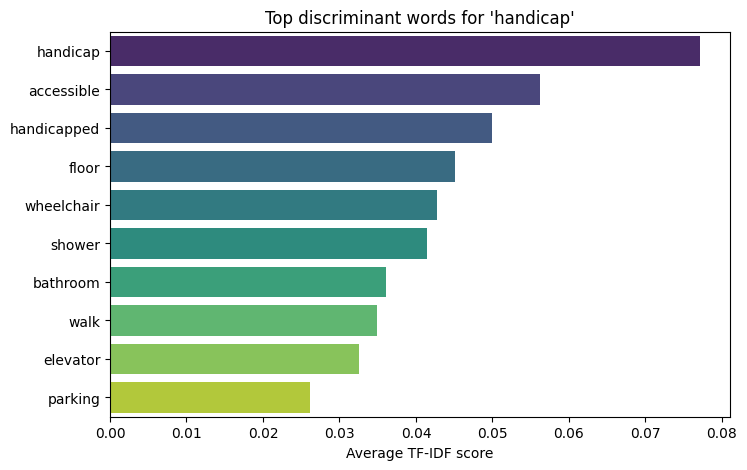

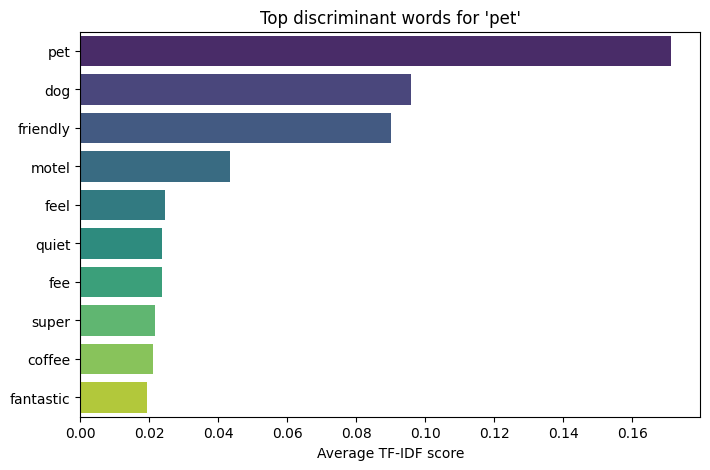

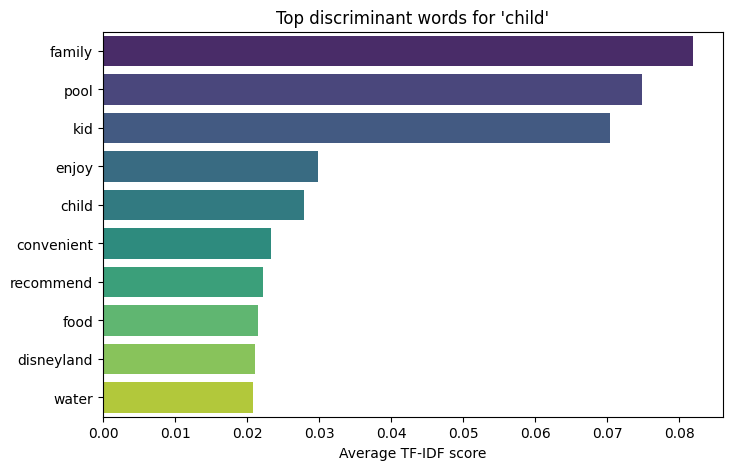

In [61]:
for cat in discriminant_words:
    top_words = discriminant_words[cat][:10]  
    scores = [tfidf_value[cat][w] for w in top_words]
    
    df_plot = pd.DataFrame({"word": top_words, "tfidf": scores})
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_plot, x="tfidf", y="word", palette="viridis", hue="word", dodge=False, legend=False)
    plt.title(f"Top discriminant words for '{cat}'")
    plt.xlabel("Average TF-IDF score")
    plt.ylabel("")
    plt.show()


## Topic Modeling with NMF

NMF (Non-Negative Matrix Factorization) is an unsupervised technique that factorizes a matrix into two smaller matrices with only non-negative coefficients. When applied to text, it can identify topics or recurring themes in a corpus of reviews by grouping words that often appear together. This is particularly useful for highlighting the recurring needs or preferences of travelers with specials needs.


Documents per topic:
Topic 0: 113 reviews
Topic 1: 34 reviews
Topic 2: 53 reviews


C:\Users\emma\AppData\Local\Temp\ipykernel_5532\1903578137.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="weight", y="word", palette="viridis")


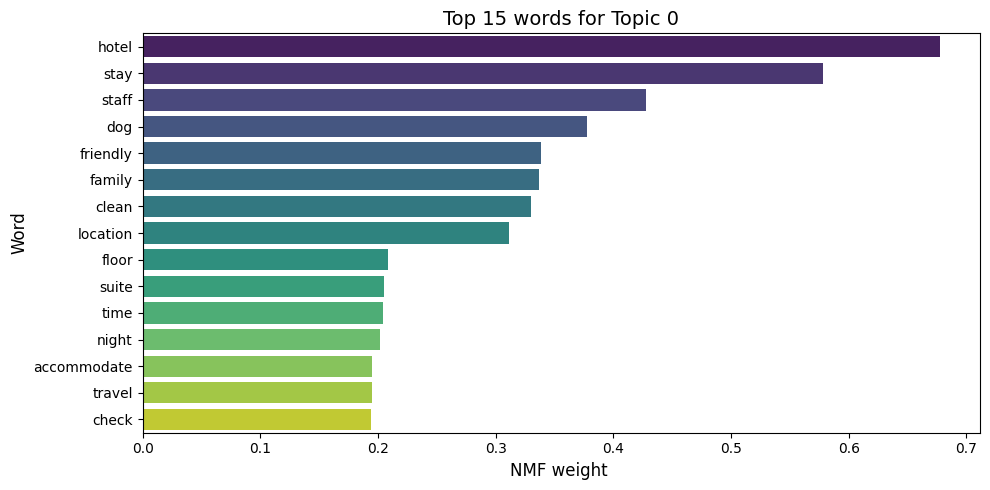

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\1903578137.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="weight", y="word", palette="viridis")


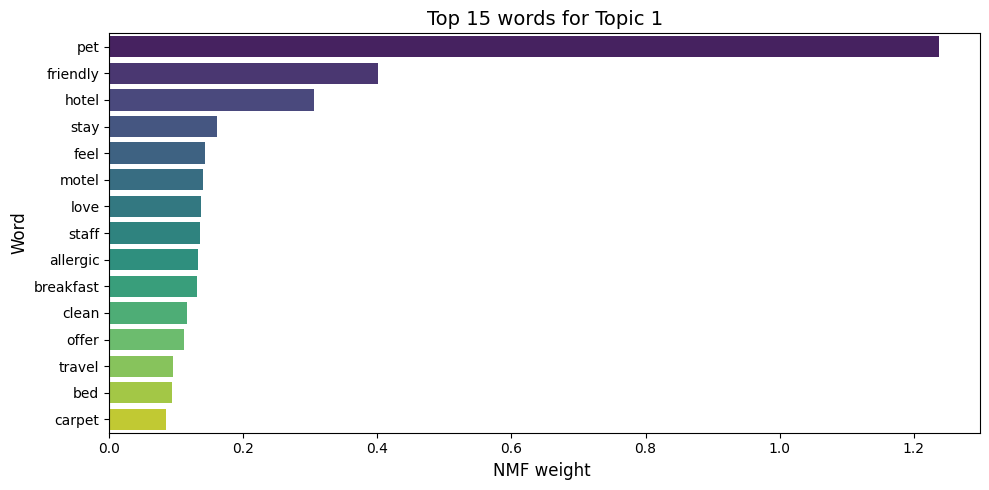

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\1903578137.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="weight", y="word", palette="viridis")


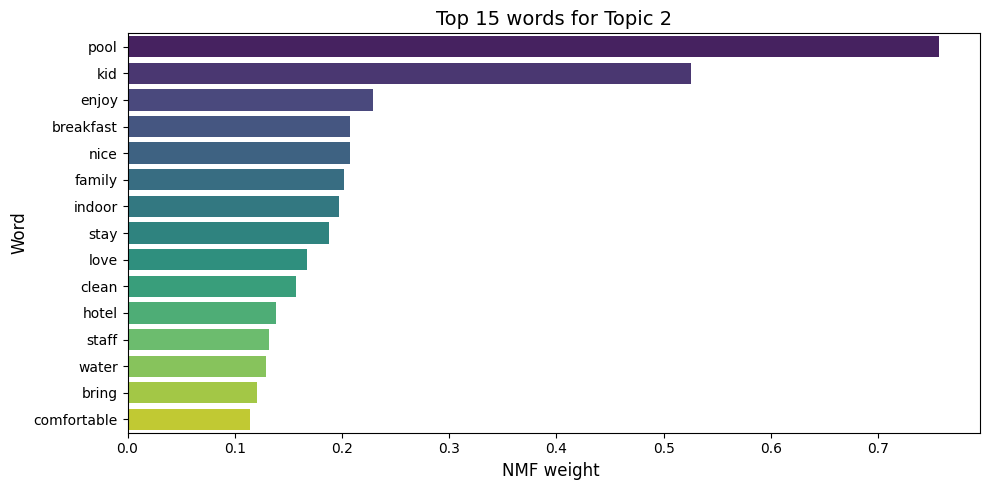

In [63]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

reviews = df['review_lemmatized'].to_list()

# TF-IDF Vectorization
X = vectorizer.fit_transform(reviews)
feature_names = vectorizer.get_feature_names_out()

# NMF Topic Modeling
n_topics = 3  # number of topic to find
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
nmf_model.fit(X)


n_top_words = 15
topics = {}

for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    topics[topic_idx] = top_words


# Match each review to its main topic
doc_topic_dist = nmf_model.transform(X)  
dominant_topics = np.argmax(doc_topic_dist, axis=1)
df = df.with_columns([
    pl.Series("dominant_topic", dominant_topics)
])

# Number of documents per topics
topic_counts = (
    df.group_by("dominant_topic")  
      .len()                    
      .sort("dominant_topic")     
)
print("\nDocuments per topic:")
for row in topic_counts.iter_rows():
    topic_idx = row[0]  
    count = row[1]      
    print(f"Topic {topic_idx}: {count} reviews")

# Visualization
for topic_idx, words in topics.items():
    word_indices = [vectorizer.vocabulary_[w] for w in words]
    weights = nmf_model.components_[topic_idx][word_indices]
    df_plot = pd.DataFrame({"word": words, "weight": weights})
    df_plot = df_plot.sort_values("weight", ascending=False)

    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x="weight", y="word", palette="viridis")
    plt.title(f"Top {n_top_words} words for Topic {topic_idx}", fontsize=14)
    plt.xlabel("NMF weight ", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.tight_layout()
    plt.show()

This is simply code to monitor training and visualize whether the model has converged or not, as well as the reconstruction error. The reconstruction error has no given threshold, but it can provide information when comparing two configurations. The lower the error, the more relevant the configuration.

NMF was executed for 61 iterations (max 100)
NMF converged before reaching the maximum number of iterations.
Final reconstruction error: 13.4392


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 30 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 40 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum n

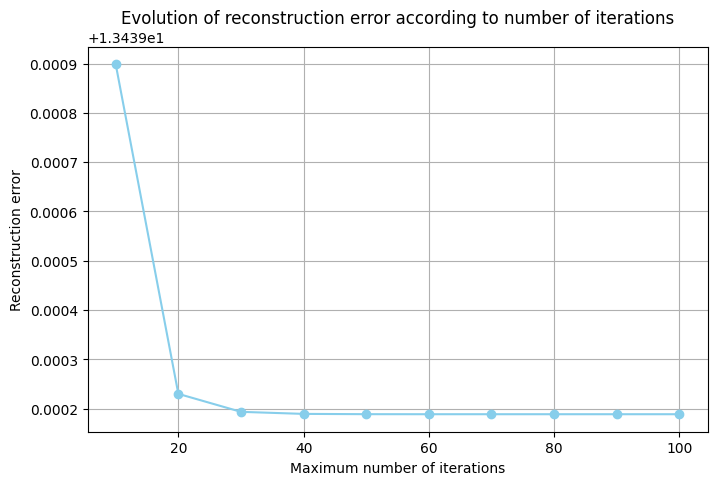

In [64]:
# Parameters
n_topics = 3
max_iter = 100 

reviews = df['review_lemmatized'].to_list()
X = vectorizer.fit_transform(reviews)

nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=max_iter)
nmf_model.fit(X)

print(f"NMF was executed for {nmf_model.n_iter_} iterations (max {max_iter})")
if nmf_model.n_iter_ == max_iter:
    print("The model reached the maximum number of iterations and may not have fully converged.")
else:
    print("NMF converged before reaching the maximum number of iterations.")

print(f"Final reconstruction error: {nmf_model.reconstruction_err_:.4f}")


# Error evaluation
reconstruction_errors = []
iter_range = range(10, max_iter+1, 10)
for it in iter_range:
    nmf_temp = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=it)
    nmf_temp.fit(X)
    reconstruction_errors.append(nmf_temp.reconstruction_err_)

plt.figure(figsize=(8,5))
plt.plot(iter_range, reconstruction_errors, marker='o', color='skyblue')
plt.xlabel("Maximum number of iterations")
plt.ylabel("Reconstruction error")
plt.title("Evolution of reconstruction error according to number of iterations")
plt.grid(True)
plt.show()


### NMF per categories

In [65]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

n_topics = 3
n_top_words = 15

categories = df["category"].unique().to_list()

for cat in categories:
    print(f"\n===============================")
    print(f"====== CATEGORY: {cat} ======")
    print(f"===============================\n")

    # --- Filtrer les reviews ---
    df_cat = df.filter(pl.col("category") == cat)
    reviews_cat = df_cat["review_lemmatized"].to_list()

    if len(reviews_cat) < n_topics:
        print(f"Pas assez de documents ({len(reviews_cat)}) pour faire du NMF.")
        continue

    # --- TF-IDF ---
    # vectorizer = TfidfVectorizer(
    #     max_df=0.95,
    #     min_df=2,
    #     stop_words="english"
    # )
    X_cat = vectorizer.fit_transform(reviews_cat)
    feature_names = vectorizer.get_feature_names_out()

    # --- NMF ---
    nmf_model = NMF(
        n_components=n_topics,
        random_state=0,
        init='nndsvda',
        max_iter=200
    ).fit(X_cat)

    # --- Affichage des topics ---
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"\n--- Topic {topic_idx} ---")

        top_idx = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_idx]

        for rank, w in enumerate(top_words, start=1):
            print(f"{rank}. {w}")

    # --- Attribution du topic dominant ---
    doc_topic_dist = nmf_model.transform(X_cat)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    print("\nDistribution des topics dans cette catégorie :")
    (pd.Series(dominant_topics)
        .value_counts()
        .sort_index()
        .rename("count")
        .to_frame()
        .style
        .format())
    
    print("\n-------------------------------------------\n")

print("\nFINISHED ✔")



====== CATEGORY: pet ======


--- Topic 0 ---
1. pet
2. hotel
3. travel
4. breakfast
5. friendly
6. feel
7. time
8. excellent
9. grit
10. serve
11. family
12. carpet
13. stay
14. pot
15. smoking

--- Topic 1 ---
1. dog
2. hotel
3. love
4. stay
5. pool
6. friendly
7. beautiful
8. time
9. fantastic
10. service
11. perfect
12. clean
13. trip
14. quiet
15. super

--- Topic 2 ---
1. friendly
2. clean
3. nice
4. staff
5. comfortable
6. bed
7. stay
8. motel
9. helpful
10. pet
11. offer
12. allergic
13. breakfast
14. egg
15. cheap

Distribution des topics dans cette catégorie :

-------------------------------------------


====== CATEGORY: handicap ======


--- Topic 0 ---
1. hotel
2. staff
3. walk
4. pool
5. floor
6. shower
7. handicap
8. beach
9. breakfast
10. clean
11. elevator
12. nice
13. towel
14. door
15. extremely

--- Topic 1 ---
1. person
2. veteran
3. sit
4. service
5. lazy
6. refuse
7. respect
8. handicapped
9. wheelchair
10. people
11. deplorable
12. fat
13. treatment
14. disabl

### Visualization of NMF in 2D


=== CATEGORY: handicap ===

=== CATEGORY: pet ===

=== CATEGORY: child ===

=== NMF terminé pour toutes les catégories ===

TABLEAU DES TOP 3 MOTS PAR TOPIC



c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,category,topic,top_1,top_2,top_3
20,child,0,staff,helpful,food
21,child,1,kid,fun,enjoy
22,child,2,suite,travel,bedroom
23,child,3,size,child,nice
24,child,4,disneyland,anaheim,wife
25,child,5,day,inn,family
26,child,6,hotel,recommend,stay
27,child,7,convenient,neighborhood,family
28,child,8,pool,water,swim
29,child,9,restaurant,pick,fancy


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Calcul UMAP en cours...
UMAP terminé.


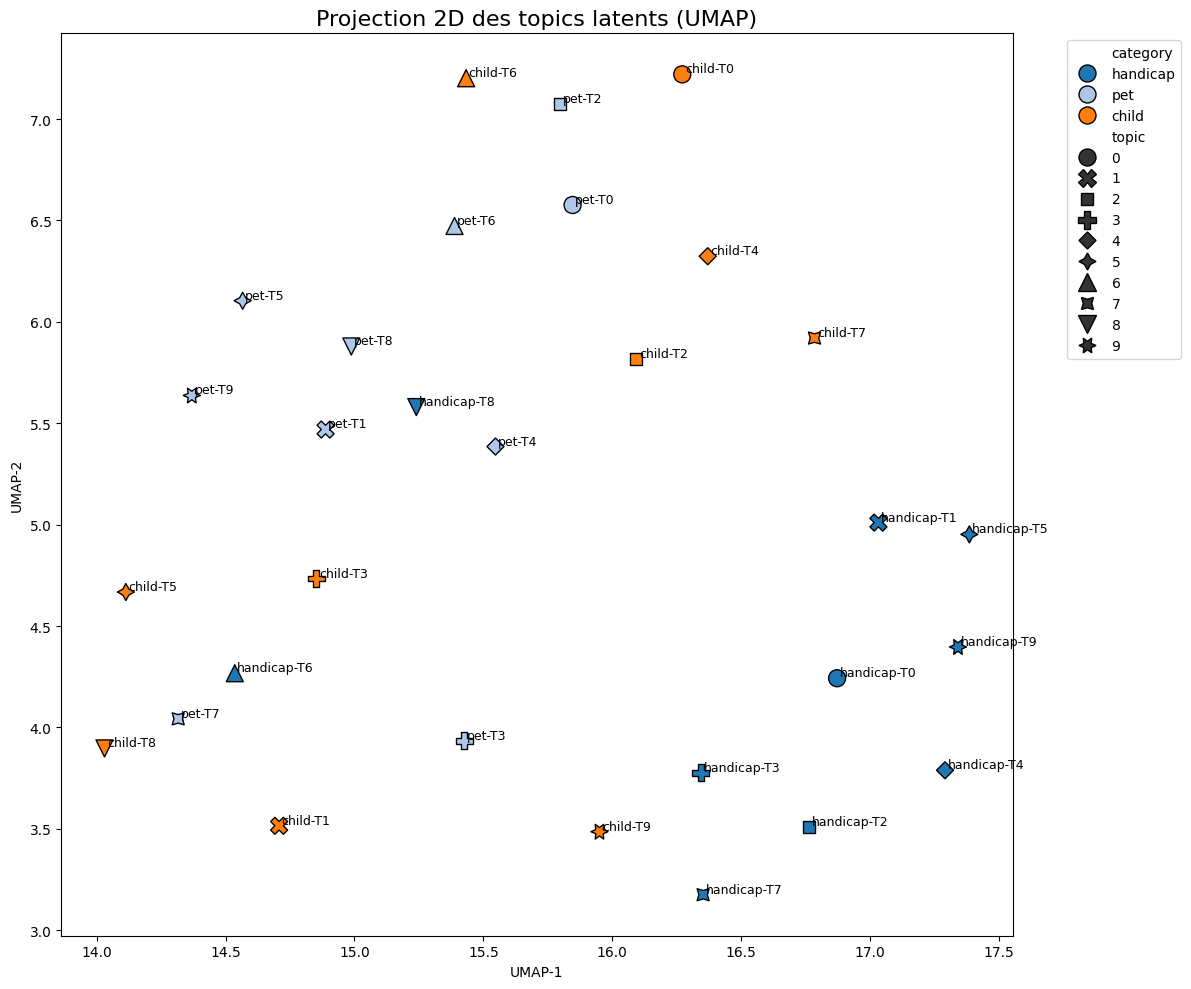


✔ Script complet exécuté avec succès


In [68]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# ============================================
# CONFIGURATION
# ============================================
n_topics = 10
n_top_words = 3   # pour le tableau final

categories = df["category"].unique().to_list()

rows = []            # pour le tableau final
topic_vectors = []   # pour UMAP

# ============================================
# TF-IDF GLOBAL (tous les reviews)
# ============================================
all_reviews = df["review_lemmatized"].to_list()
# vectorizer = TfidfVectorizer(
#     max_df=0.95,
#     min_df=2,
#     stop_words="english"
# )
X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# ============================================
# NMF PAR CATÉGORIE
# ============================================
for cat in categories:
    print(f"\n=== CATEGORY: {cat} ===")

    # Filtrer la catégorie
    df_cat = df.filter(pl.col("category") == cat)
    reviews_cat = df_cat["review_lemmatized"].to_list()

    if len(reviews_cat) < n_topics:
        print("Pas assez de documents pour faire du NMF.")
        continue

    # TF-IDF global pour cette catégorie
    X_cat_global = vectorizer.transform(reviews_cat)
    feature_names = global_feature_names

    # NMF
    nmf_model = NMF(
        n_components=n_topics,
        random_state=0,
        init='nndsvda',
        max_iter=200
    ).fit(X_cat_global)

    # Extraction des topics
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_idx]

        # Ajouter au tableau
        rows.append({
            "category": cat,
            "topic": topic_idx,
            "top_1": top_words[0],
            "top_2": top_words[1] if len(top_words) > 1 else "",
            "top_3": top_words[2] if len(top_words) > 2 else "",
        })

        # Ajouter vecteur pour UMAP
        topic_vectors.append({
            "category": cat,
            "topic": topic_idx,
            "vector": topic
        })

print("\n=== NMF terminé pour toutes les catégories ===")

# ============================================
# TABLEAU FINAL
# ============================================
df_topics = pd.DataFrame(rows)
df_topics = df_topics.sort_values(["category", "topic"])
print("\nTABLEAU DES TOP 3 MOTS PAR TOPIC\n")
display(df_topics)

# ============================================
# UMAP — Projection 2D des topics latents
# ============================================
print("\nCalcul UMAP en cours...")

df_vec = pd.DataFrame(topic_vectors)
X_topics = np.vstack(df_vec["vector"].to_list())

# UMAP 2D
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1,
    random_state=42
)
coords = reducer.fit_transform(X_topics)
df_vec["x"] = coords[:, 0]
df_vec["y"] = coords[:, 1]

print("UMAP terminé.")

# ============================================
# VISUALISATION
# ============================================
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_vec,
    x="x", y="y",
    hue="category",
    style="topic",
    s=150,
    palette="tab20",
    edgecolor="black"
)

# Étiquettes
for _, row in df_vec.iterrows():
    plt.text(
        row["x"] + 0.01,
        row["y"] + 0.01,
        f'{row["category"][:10]}-T{row["topic"]}',
        fontsize=9
    )

plt.title("Projection 2D des topics latents (UMAP)", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n✔ Script complet exécuté avec succès")


### Projection en 2D des reviews totale

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\2684440643.py:38: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\2684440643.py:38: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\2684440643.py:38: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
c:\Users\emma\Desktop\project\large-proj


--- Diagnostic pour la catégorie : child (Topics=4) ---
Moyenne des scores par topic: [0.04522722 0.02952424 0.03457227 0.04424389]
Comptage des topics dominants: [32 16 18 27]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : handicap (Topics=4) ---
Moyenne des scores par topic: [0.03158677 0.04746526 0.03717517 0.01918918]
Comptage des topics dominants: [13 19 10  4]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : pet (Topics=4) ---
Moyenne des scores par topic: [0.03899594 0.05853564 0.02902113 0.02021945]
Comptage des topics dominants: [17 26 10  8]
------------------------------------------------------------------


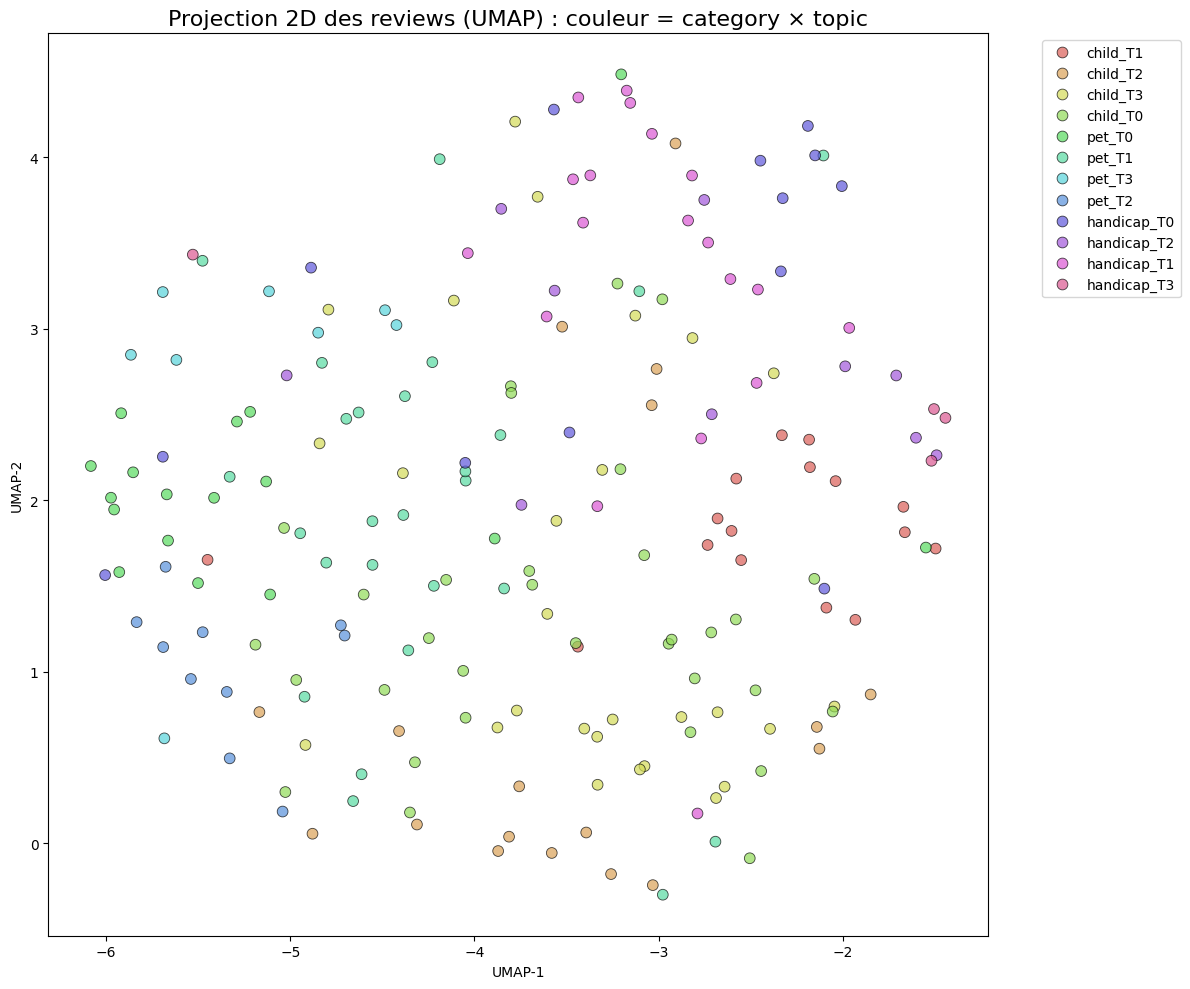

In [70]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# ============================================
# CONFIGURATION
# ============================================

n_topics = 4
categories = df["category"].unique().to_list()

# TF-IDF global pour toutes les reviews
all_reviews = df["review_lemmatized"].to_list()

# vectorizer_global = TfidfVectorizer(
#     max_df=0.95,
#     min_df=1,
#     stop_words="english"
# )

X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# Array pour stocker le topic dominant de chaque review (initialisé à 0)
dominant_topics_per_review = np.zeros(len(df), dtype=int)

# ============================================
# NMF PAR CATÉGORIE + attribution topic dominant (CORRIGÉ)
# ============================================
for cat in categories:
    # 1. Ajouter l'index global et filtrer
    df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
    
    reviews_cat = df_cat_with_index["review_lemmatized"].to_list()
    
    if len(reviews_cat) < n_topics:
        # Gérer les catégories trop petites pour avoir n_topics distincts
        n_topics_cat = max(1, len(reviews_cat))
    else:
        n_topics_cat = n_topics
        
    if n_topics_cat == 0:
        continue # Skip si aucune review

    # Récupérer l'index global pour cette catégorie
    idxs_cat = df_cat_with_index["global_index"].to_numpy().flatten() # Indices dans le df global
    
    # Transformer avec TF-IDF global (Même espace de caractéristiques)
    X_cat_global = vectorizer.transform(reviews_cat)

    # NMF (Nous utilisons init='random' pour aider à la séparation si 'nndsvda' ne fonctionne pas bien)
    nmf_model = NMF(
        n_components=n_topics_cat,
        random_state=0,
        init='random', # Initialisation aléatoire pour aider à la séparation des topics
        max_iter=500 # Plus d'itérations pour une meilleure convergence
    ).fit(X_cat_global)

    # Calculer la distribution Doc-Topic et trouver le topic dominant
    doc_topic_dist = nmf_model.transform(X_cat_global)
    dominant_topics = np.argmax(doc_topic_dist, axis=1) # Topics pour le sous-ensemble

    # 2. ASSIGNATION ROBUSTE : Mettre à jour l'array NumPy global avec les topics
    dominant_topics_per_review[idxs_cat] = dominant_topics
    
    # OPTIONNEL : Afficher le diagnostic après le calcul NMF pour vérifier la répartition
    print(f"\n--- Diagnostic pour la catégorie : {cat} (Topics={n_topics_cat}) ---")
    mean_scores = np.mean(doc_topic_dist, axis=0)
    print(f"Moyenne des scores par topic: {mean_scores}")
    dominant_counts = np.bincount(dominant_topics, minlength=n_topics_cat)
    print(f"Comptage des topics dominants: {dominant_counts}")
    print("------------------------------------------------------------------")

# Ajouter la colonne topic dominant
df = df.with_columns([pl.Series("dominant_topic", dominant_topics_per_review)])

# ============================================
# Créer colonne combinée category × topic
# ============================================
df = df.with_columns([
    (pl.col("category") + "_T" + pl.col("dominant_topic").cast(pl.Utf8)).alias("cat_topic")
])

# ============================================
# UMAP sur toutes les reviews
# ============================================
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
# Utiliser l'espace TF-IDF global (X_global)
X_reviews_embedded = reducer.fit_transform(X_global) 

df_reviews_embedded = pd.DataFrame({
    "x": X_reviews_embedded[:,0],
    "y": X_reviews_embedded[:,1],
    # Convertir la colonne cat_topic de Polars à Pandas/Numpy pour le DataFrame de visualisation
    "cat_topic": df["cat_topic"].to_list() 
})

# ============================================
# VISUALISATION
# ============================================
plt.figure(figsize=(12,10))

# Palette : autant de couleurs que de combinaisons uniques
unique_cat_topics = df_reviews_embedded["cat_topic"].unique()
# Utiliser une palette plus large comme 'tab20' ou 'hls' pour 9+ couleurs
palette = sns.color_palette("hls", n_colors=len(unique_cat_topics)) 

sns.scatterplot(
    data=df_reviews_embedded,
    x="x",
    y="y",
    hue="cat_topic",
    palette=palette,
    s=60,
    alpha=0.7,
    edgecolor="k"
)

plt.title("Projection 2D des reviews (UMAP) : couleur = category × topic", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

### Projection en 2D par categories

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3598274231.py:43: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3598274231.py:43: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3598274231.py:43: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykern


--- Diagnostic pour la catégorie : pet (Topics=4) ---
Moyenne des scores par topic: [0.03899594 0.05853564 0.02902113 0.02021945]
Comptage des topics dominants: [17 26 10  8]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : handicap (Topics=4) ---
Moyenne des scores par topic: [0.03158677 0.04746526 0.03717517 0.01918918]
Comptage des topics dominants: [13 19 10  4]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : child (Topics=4) ---
Moyenne des scores par topic: [0.04522722 0.02952424 0.03457227 0.04424389]
Comptage des topics dominants: [32 16 18 27]
------------------------------------------------------------------

Génération de la figure pour la catégorie: pet


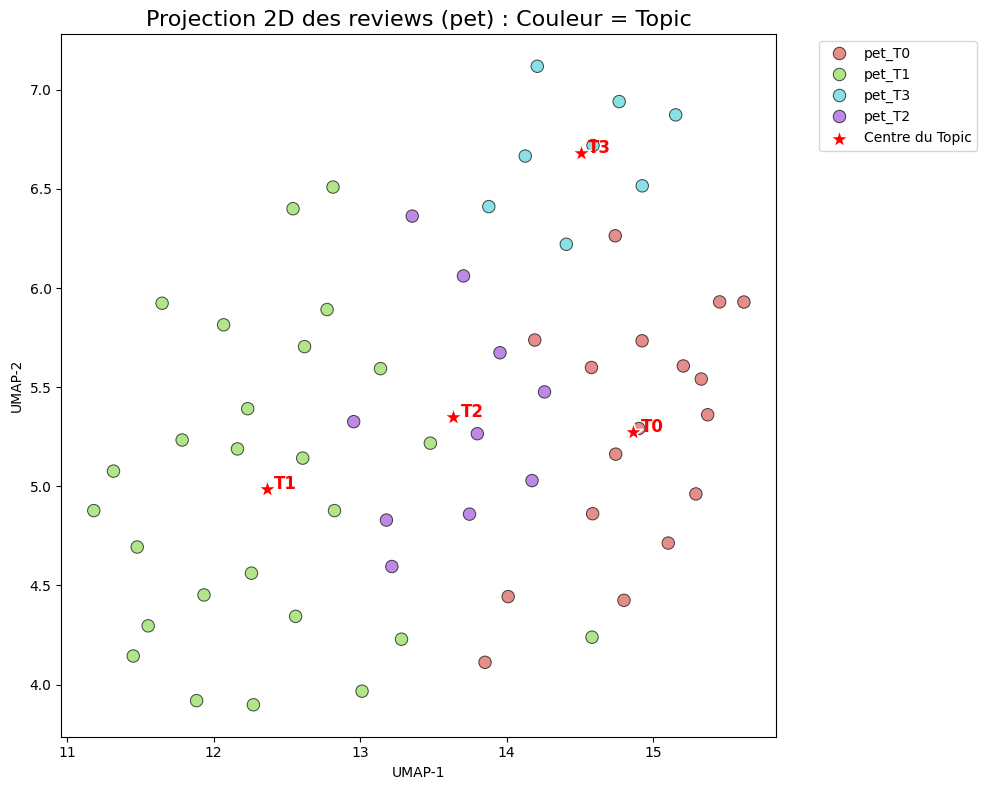


Génération de la figure pour la catégorie: handicap


C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3598274231.py:112: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index"].to_numpy().flatten()
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


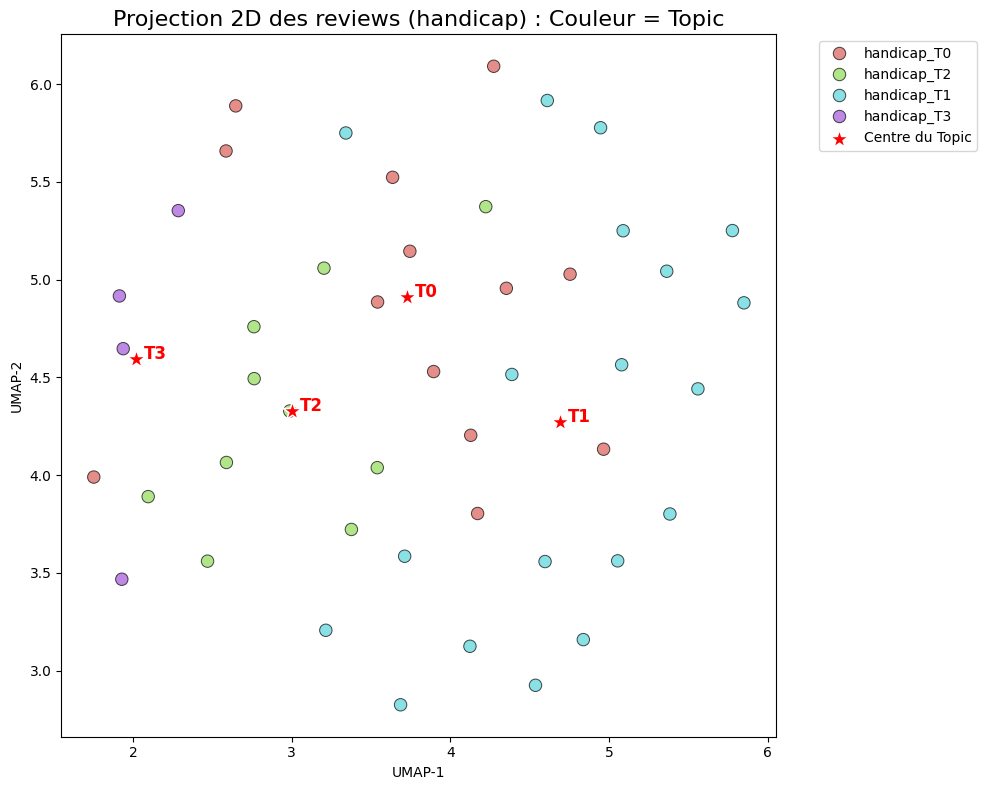


Génération de la figure pour la catégorie: child


C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3598274231.py:112: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index"].to_numpy().flatten()
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


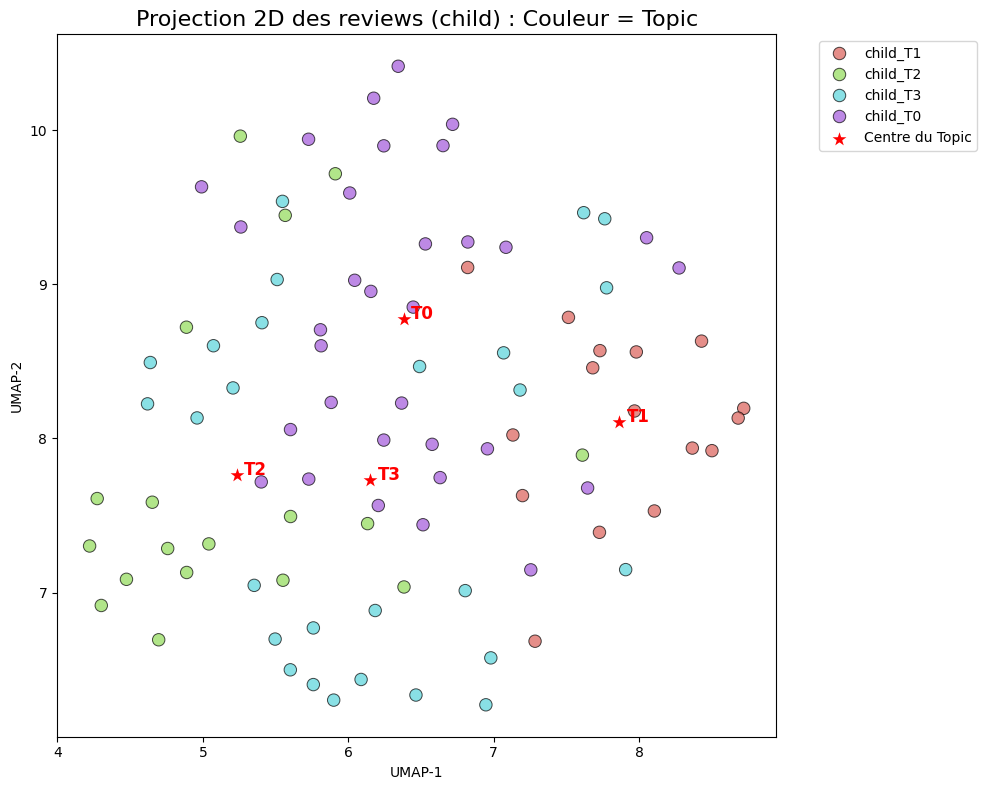


--- Fin de la génération des figures ---


In [71]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# ============================================
# ⚠️ PRÉPARATION DES DONNÉES ⚠️
# Votre code de chargement de df doit être ici.
# ============================================


# ============================================
# CONFIGURATION
# ============================================

n_topics = 4
categories = df["category"].unique().to_list()

# TF-IDF global pour toutes les reviews
all_reviews = df["review_lemmatized"].to_list()

# vectorizer_global = TfidfVectorizer(
#     max_df=0.95,
#     min_df=1,
#     stop_words="english"
# )

X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# Array pour stocker le topic dominant de chaque review (initialisé à 0)
dominant_topics_per_review = np.zeros(len(df), dtype=int)

# ============================================
# NMF PAR CATÉGORIE + attribution topic dominant (PAS DE CHANGEMENT)
# ============================================
for cat in categories:
    # 1. Ajouter l'index global et filtrer
    df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
    
    reviews_cat = df_cat_with_index["review_lemmatized"].to_list()
    
    if len(reviews_cat) < n_topics:
        n_topics_cat = max(1, len(reviews_cat))
    else:
        n_topics_cat = n_topics
        
    if n_topics_cat == 0:
        continue

    # Récupérer l'index global pour cette catégorie
    idxs_cat = df_cat_with_index["global_index"].to_numpy().flatten()
    
    # Transformer avec TF-IDF global (Même espace de caractéristiques)
    # X_cat_global est utilisé ici uniquement pour l'entraînement NMF
    X_cat_global = vectorizer.transform(reviews_cat)

    # NMF
    nmf_model = NMF(
        n_components=n_topics_cat,
        random_state=0,
        init='random',
        max_iter=500
    ).fit(X_cat_global)

    # Calculer la distribution Doc-Topic et trouver le topic dominant
    doc_topic_dist = nmf_model.transform(X_cat_global)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    # ASSIGNATION ROBUSTE
    dominant_topics_per_review[idxs_cat] = dominant_topics
    
    # OPTIONNEL : Afficher le diagnostic
    print(f"\n--- Diagnostic pour la catégorie : {cat} (Topics={n_topics_cat}) ---")
    mean_scores = np.mean(doc_topic_dist, axis=0)
    print(f"Moyenne des scores par topic: {mean_scores}")
    dominant_counts = np.bincount(dominant_topics, minlength=n_topics_cat)
    print(f"Comptage des topics dominants: {dominant_counts}")
    print("------------------------------------------------------------------")

# Ajouter la colonne topic dominant
df = df.with_columns([pl.Series("dominant_topic", dominant_topics_per_review)])

# ============================================
# Créer colonne combinée category × topic
# ============================================
df = df.with_columns([
    (pl.col("category") + "_T" + pl.col("dominant_topic").cast(pl.Utf8)).alias("cat_topic")
])

# ============================================
# UMAP et VISUALISATION PAR CATÉGORIE (MODIFIÉE)
# ============================================

# Nous allons itérer sur chaque catégorie et recalculer UMAP et le graphique à chaque fois
for cat in categories:
    print(f"\nGénération de la figure pour la catégorie: {cat}")
    
    # 1. Filtrer les données (Polars)
    df_cat = df.filter(pl.col("category") == cat)
    
    # Vérifier s'il y a des données à traiter
    if len(df_cat) == 0:
        continue
    
    # Filtrer la matrice TF-IDF globale pour cette catégorie
    # On récupère les indices globaux de cette catégorie
    idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index"].to_numpy().flatten()
    X_cat_matrix = X_global[idxs_cat_all, :] # Matrice TF-IDF spécifique à la catégorie

    # 2. UMAP spécifique à la catégorie
    # UMAP est entraîné uniquement sur la matrice de cette catégorie
    reducer = umap.UMAP(
        n_neighbors=min(15, len(df_cat) - 1), # Ajuster n_neighbors si le jeu de données est petit
        min_dist=0.1,
        random_state=42
    )
    X_reviews_embedded = reducer.fit_transform(X_cat_matrix)
    
    # 3. Création du DataFrame Pandas pour la visualisation
    df_reviews_embedded = pd.DataFrame({
        "x": X_reviews_embedded[:,0],
        "y": X_reviews_embedded[:,1],
        "cat_topic": df_cat["cat_topic"].to_list(),
        "dominant_topic_id": df_cat["dominant_topic"].to_list()
    })
    
    # 4. Visualisation
    plt.figure(figsize=(10, 8))
    
    # Palette : Seulement les topics de cette catégorie (ex: pet_T0, pet_T1)
    unique_cat_topics = df_reviews_embedded["cat_topic"].unique()
    palette = sns.color_palette("hls", n_colors=len(unique_cat_topics))
    
    sns.scatterplot(
        data=df_reviews_embedded,
        x="x",
        y="y",
        hue="cat_topic",
        palette=palette,
        s=80,
        alpha=0.7,
        edgecolor="k"
    )

    # Ajouter le centre des clusters (les topics)
    topic_centers = df_reviews_embedded.groupby('cat_topic')[['x', 'y']].mean().reset_index()
    
    sns.scatterplot(
        data=topic_centers,
        x="x",
        y="y",
        color='red',
        s=200,
        marker='*',
        label='Centre du Topic',
        zorder=3
    )
    
    # Optionnel: Ajouter le numéro du topic à côté du centre
    for index, row in topic_centers.iterrows():
        plt.text(row['x'] + 0.05, row['y'], 
                 f"T{df_reviews_embedded[df_reviews_embedded['cat_topic'] == row['cat_topic']]['dominant_topic_id'].iloc[0]}",
                 fontsize=12, weight='bold', color='red')

    plt.title(f"Projection 2D des reviews ({cat}) : Couleur = Topic", fontsize=16)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

print("\n--- Fin de la génération des figures ---")

### avec les nuages englobants

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\354014456.py:45: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\354014456.py:45: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\354014456.py:45: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)



--- Diagnostic pour la catégorie : handicap (Topics=4) ---
Moyenne des scores par topic: [0.03158677 0.04746526 0.03717517 0.01918918]
Comptage des topics dominants: [13 19 10  4]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : pet (Topics=4) ---
Moyenne des scores par topic: [0.03899594 0.05853564 0.02902113 0.02021945]
Comptage des topics dominants: [17 26 10  8]
------------------------------------------------------------------

--- Diagnostic pour la catégorie : child (Topics=4) ---
Moyenne des scores par topic: [0.04522722 0.02952424 0.03457227 0.04424389]
Comptage des topics dominants: [32 16 18 27]
------------------------------------------------------------------

Préparation de la visualisation pour la catégorie: handicap


C:\Users\emma\AppData\Local\Temp\ipykernel_5532\354014456.py:124: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index"].to_numpy().flatten()
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidt


Préparation de la visualisation pour la catégorie: pet


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\354014456.py:124: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index


Préparation de la visualisation pour la catégorie: child


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


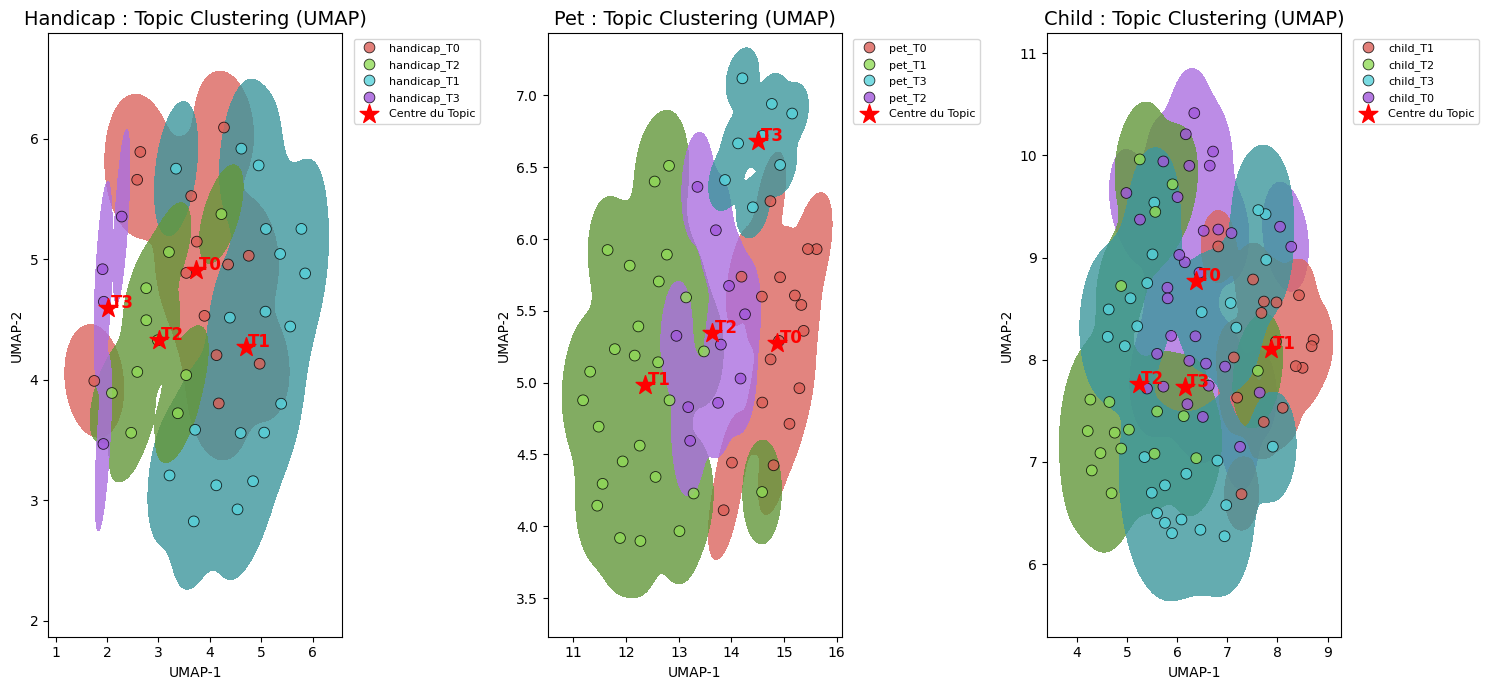


--- Fin de la génération des figures côte à côte ---


In [72]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# ============================================
# ⚠️ PRÉPARATION DES DONNÉES ⚠️
# VOUS DEVEZ CHARGER VOTRE DATAFRAME POLARS 'df' ICI.
# ============================================
# Votre code de chargement de df doit être ici.
# ============================================


# ============================================
# CONFIGURATION
# ============================================
n_topics = 4
categories = df["category"].unique().to_list()
n_categories = len(categories) # Nombre de catégories pour les subplots

# TF-IDF global pour toutes les reviews
all_reviews = df["review_lemmatized"].to_list()

# vectorizer_global = TfidfVectorizer(
#     max_df=0.95,
#     min_df=1,
#     stop_words="english"
# )

X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# Array pour stocker le topic dominant de chaque review (initialisé à 0)
dominant_topics_per_review = np.zeros(len(df), dtype=int)

# ============================================
# NMF PAR CATÉGORIE + attribution topic dominant
# ============================================
for cat in categories:
    # 1. Ajouter l'index global et filtrer
    df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
    
    reviews_cat = df_cat_with_index["review_lemmatized"].to_list()
    
    # Définir le nombre de topics pour cette catégorie
    if len(reviews_cat) < n_topics:
        n_topics_cat = max(1, len(reviews_cat))
    else:
        n_topics_cat = n_topics
        
    if n_topics_cat == 0:
        continue

    # Récupérer l'index global pour cette catégorie
    idxs_cat = df_cat_with_index["global_index"].to_numpy().flatten()
    
    # Transformer avec TF-IDF global
    X_cat_global = vectorizer.transform(reviews_cat)

    # NMF
    nmf_model = NMF(
        n_components=n_topics_cat,
        random_state=0,
        init='random',
        max_iter=500
    ).fit(X_cat_global)

    # Calculer la distribution Doc-Topic et trouver le topic dominant
    doc_topic_dist = nmf_model.transform(X_cat_global)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    # ASSIGNATION ROBUSTE
    dominant_topics_per_review[idxs_cat] = dominant_topics
    
    # OPTIONNEL : Afficher le diagnostic
    print(f"\n--- Diagnostic pour la catégorie : {cat} (Topics={n_topics_cat}) ---")
    mean_scores = np.mean(doc_topic_dist, axis=0)
    print(f"Moyenne des scores par topic: {mean_scores}")
    dominant_counts = np.bincount(dominant_topics, minlength=n_topics_cat)
    print(f"Comptage des topics dominants: {dominant_counts}")
    print("------------------------------------------------------------------")

# Ajouter la colonne topic dominant
df = df.with_columns([pl.Series("dominant_topic", dominant_topics_per_review)])

# ============================================
# Créer colonne combinée category × topic
# ============================================
df = df.with_columns([
    (pl.col("category") + "_T" + pl.col("dominant_topic").cast(pl.Utf8)).alias("cat_topic")
])

# ============================================
# UMAP et VISUALISATION PAR CATÉGORIE (Côte à côte, KDE par Topic)
# ============================================

# Création des subplots : 1 ligne, N colonnes (N = nombre de catégories)
fig, axes = plt.subplots(1, n_categories, figsize=(5 * n_categories, 7))

# Gérer le cas où il n'y a qu'un seul subplot
if n_categories == 1:
    axes = [axes] 

# Minimum de points requis pour dessiner un contour rempli (KDE)
MIN_POINTS_FOR_KDE = 3 

# Nous allons itérer sur chaque catégorie
for i, cat in enumerate(categories):
    ax = axes[i] # Sélectionner l'axe courant pour le tracé
    print(f"\nPréparation de la visualisation pour la catégorie: {cat}")
    
    # 1. Filtrer les données (Polars)
    df_cat = df.filter(pl.col("category") == cat)
    
    if len(df_cat) <= 1:
        ax.set_title(f"{cat.capitalize()} (Données Insuffisantes)")
        continue
    
    # Filtrer la matrice TF-IDF globale pour cette catégorie
    idxs_cat_all = df.with_row_count("global_index").filter(pl.col("category") == cat)["global_index"].to_numpy().flatten()
    X_cat_matrix = X_global[idxs_cat_all, :]

    # 2. UMAP spécifique à la catégorie
    reducer = umap.UMAP(
        n_neighbors=min(15, len(df_cat) - 1),
        min_dist=0.1,
        random_state=42
    )
    X_reviews_embedded = reducer.fit_transform(X_cat_matrix)
    
    # 3. Création du DataFrame Pandas pour la visualisation
    df_reviews_embedded = pd.DataFrame({
        "x": X_reviews_embedded[:,0],
        "y": X_reviews_embedded[:,1],
        "cat_topic": df_cat["cat_topic"].to_list(),
        "dominant_topic_id": df_cat["dominant_topic"].to_list()
    })
    
    # 4. Préparation des couleurs
    unique_cat_topics = df_reviews_embedded["cat_topic"].unique()
    palette_colors = sns.color_palette("hls", n_colors=len(unique_cat_topics))
    color_map = dict(zip(unique_cat_topics, palette_colors))

    # --- 5. Ajout des Contours de Densité (KDE) basés sur 'cat_topic' (Topic) ---
    for group_name, group_data in df_reviews_embedded.groupby('cat_topic'):
        
        # VÉRIFICATION : Ignorer le KDE si le topic est trop petit
        if len(group_data) < MIN_POINTS_FOR_KDE: 
            print(f"  > Skipping KDE for {group_name}: Too few points ({len(group_data)})")
            continue

        sns.kdeplot(
            data=group_data,
            x="x",
            y="y",
            ax=ax, 
            color=color_map[group_name],
            levels=2, 
            linewidths=3, 
            alpha=0.8,
            fill=True,
            thresh=0.05,
            zorder=1,
            # MODIFICATION CRITIQUE : Ajuster la bande passante pour mieux gérer les petits clusters
            bw_adjust=0.5 
        )

    # 6. Ajout des Points (Scatterplot)
    sns.scatterplot(
        data=df_reviews_embedded,
        x="x",
        y="y",
        hue="cat_topic",
        palette=color_map, 
        s=60,
        alpha=0.8,
        edgecolor="k",
        ax=ax, 
        zorder=2
    )
    
    # 7. Ajout des Centres de Topic et des Labels
    topic_centers = df_reviews_embedded.groupby('cat_topic')[['x', 'y']].mean().reset_index()
    
    # Tracer les centres
    ax.scatter(topic_centers['x'], topic_centers['y'], 
               color='red', s=200, marker='*', label='Centre du Topic', zorder=3)
    
    # Ajouter le numéro du topic à côté du centre
    for index, row in topic_centers.iterrows():
        # Utiliser un try/except pour la robustesse au cas où il manquerait des points
        try:
            topic_id = df_reviews_embedded[df_reviews_embedded['cat_topic'] == row['cat_topic']]['dominant_topic_id'].iloc[0]
            ax.text(row['x'] + 0.05, row['y'], 
                     f"T{topic_id}",
                     fontsize=12, weight='bold', color='red')
        except IndexError:
             pass # Si le topic center n'a pas de point associé pour l'id (devrait être rare)


    ax.set_title(f"{cat.capitalize()} : Topic Clustering (UMAP)", fontsize=14)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    # Placer la légende hors du graphique
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

print("\n--- Fin de la génération des figures côte à côte ---")

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3101589202.py:37: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3101589202.py:37: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\3101589202.py:37: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
c:\Users\emma\Desktop\project\large-proj

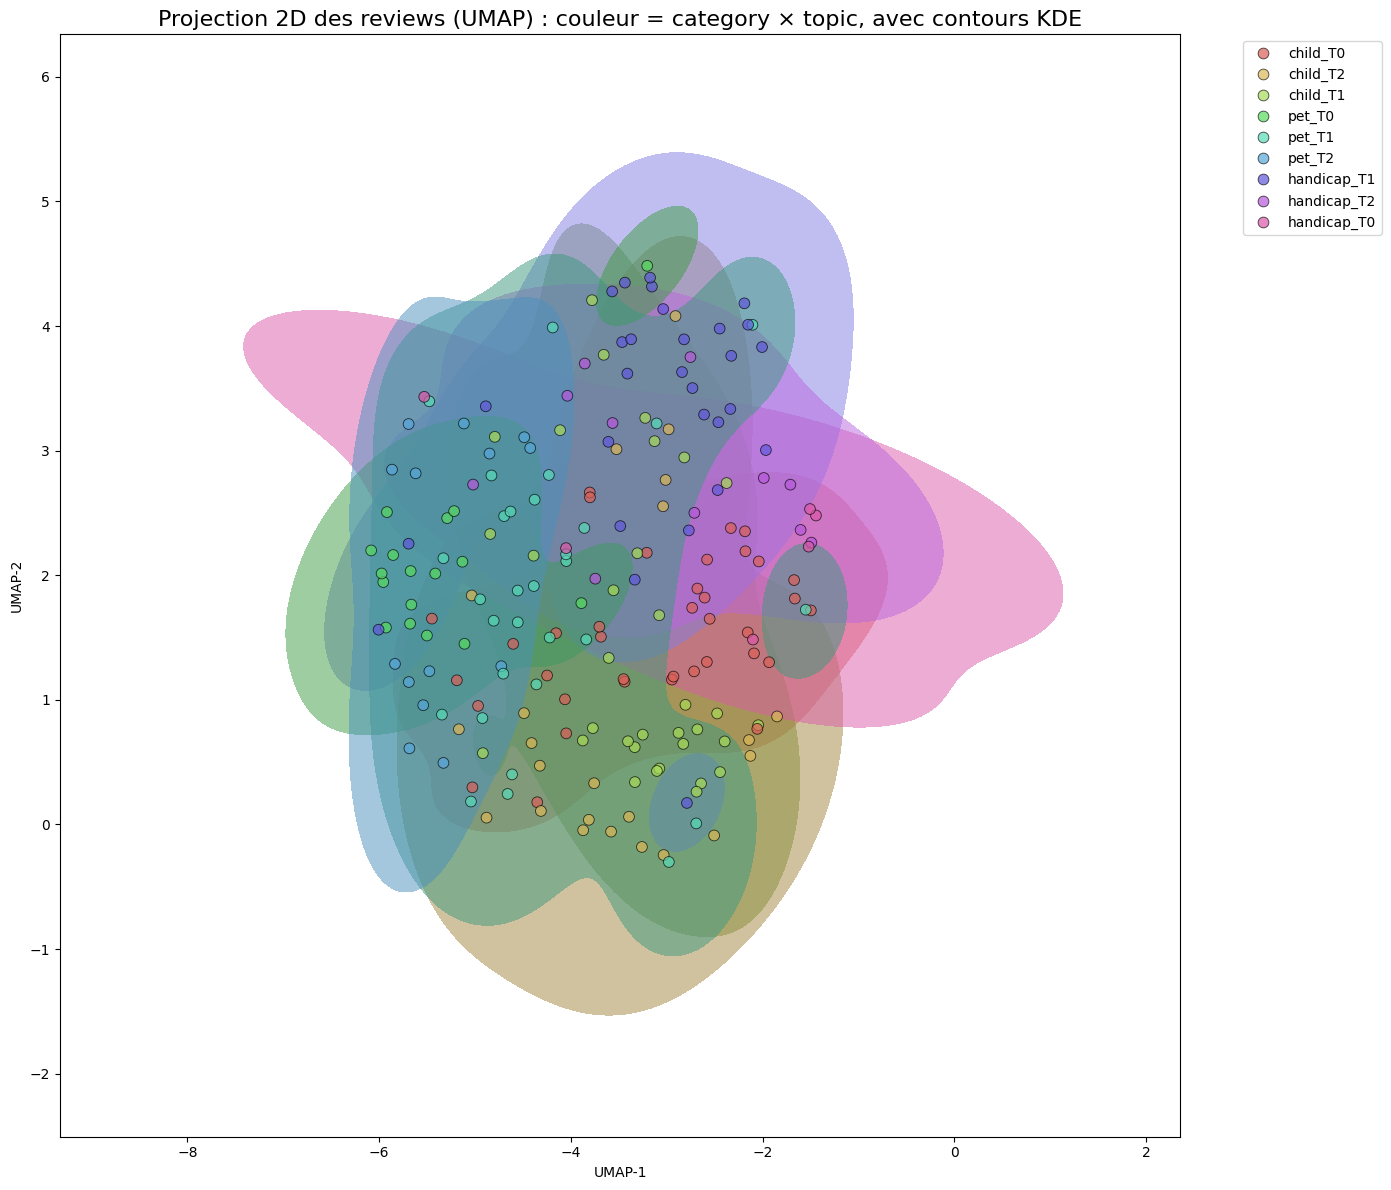

In [73]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# ============================================
# CONFIGURATION
# ============================================
# Nous utilisons n_topics = 3 pour obtenir 3 topics par catégorie (si possible)
n_topics = 3 
categories = df["category"].unique().to_list()

# TF-IDF global pour toutes les reviews
all_reviews = df["review_lemmatized"].to_list()
# vectorizer_global = TfidfVectorizer(
#     max_df=0.95,
#     min_df=1, # inclut même les petites catégories
#     stop_words="english"
# )
X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# Array pour stocker le topic dominant de chaque review (initialisé à 0)
dominant_topics_per_review = np.zeros(len(df), dtype=int)

# ============================================
# NMF PAR CATÉGORIE + attribution topic dominant
# (Correction des indices Polars/NumPy pour la robustesse)
# ============================================
for cat in categories:
    # 1. Ajouter l'index global et filtrer
    df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
    
    reviews_cat = df_cat_with_index["review_lemmatized"].to_list()
    
    # Déterminer le nombre de topics pour cette catégorie (minimum 1)
    if len(reviews_cat) < n_topics:
        n_topics_cat = max(1, len(reviews_cat))
    else:
        n_topics_cat = n_topics
        
    if n_topics_cat == 0:
        continue # Skip si aucune review

    # Récupérer l'index global pour cette catégorie
    idxs_cat = df_cat_with_index["global_index"].to_numpy().flatten()
    
    # Transformer avec TF-IDF global (Même espace de caractéristiques)
    X_cat_global = vectorizer.transform(reviews_cat)

    # NMF
    nmf_model = NMF(
        n_components=n_topics_cat,
        random_state=0,
        init='random', # Utilisation de 'random' pour aider à la séparation des topics
        max_iter=500 
    ).fit(X_cat_global)

    # Calculer la distribution Doc-Topic et trouver le topic dominant
    doc_topic_dist = nmf_model.transform(X_cat_global)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    # ASSIGNATION ROBUSTE : Mettre à jour l'array NumPy global avec les topics
    dominant_topics_per_review[idxs_cat] = dominant_topics
    
# Ajouter la colonne topic dominant
df = df.with_columns([pl.Series("dominant_topic", dominant_topics_per_review)])

# ============================================
# Créer colonne combinée category × topic
# ============================================
df = df.with_columns([
    (pl.col("category") + "_T" + pl.col("dominant_topic").cast(pl.Utf8)).alias("cat_topic")
])

# ============================================
# UMAP sur toutes les reviews
# ============================================
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
X_reviews_embedded = reducer.fit_transform(X_global) 

df_reviews_embedded = pd.DataFrame({
    "x": X_reviews_embedded[:,0],
    "y": X_reviews_embedded[:,1],
    "cat_topic": df["cat_topic"].to_list() 
})

# ============================================
# 🎨 VISUALISATION AVEC CONTOURS DE DENSITÉ (KDE) 🎨
# ============================================
plt.figure(figsize=(14,12))

# 1. Préparation de la palette de couleurs
unique_cat_topics = df_reviews_embedded["cat_topic"].unique()
palette_colors = sns.color_palette("hls", n_colors=len(unique_cat_topics))
color_map = dict(zip(unique_cat_topics, palette_colors))

# --- Ajout des Contours de Densité (KDE) pour le groupement visuel ---
for group_name, group_data in df_reviews_embedded.groupby('cat_topic'):
    sns.kdeplot(
        data=group_data,
        x="x",
        y="y",
        color=color_map[group_name],
        levels=2,
        linewidths=3,
        alpha=0.5,
        # Remplissage de la zone pour l'effet "cercle transparent"
        fill=True,
        thresh=0.1,          # Transparence de la zone remplie
        zorder=1         # Dessiné en dessous des points
    )

# 2. Ajout des Points (Scatterplot)
sns.scatterplot(
    data=df_reviews_embedded,
    x="x",
    y="y",
    hue="cat_topic",
    palette=color_map, # Utilisation de la palette cohérente
    s=60,
    alpha=0.7,
    edgecolor="k",
    zorder=2 # Dessiné au-dessus des contours
)

plt.title("Projection 2D des reviews (UMAP) : couleur = category × topic, avec contours KDE", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\emma\AppData\Local\Temp\ipykernel_5532\989071981.py:35: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\989071981.py:35: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
C:\Users\emma\AppData\Local\Temp\ipykernel_5532\989071981.py:35: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
c:\Users\emma\Desktop\project\large-project

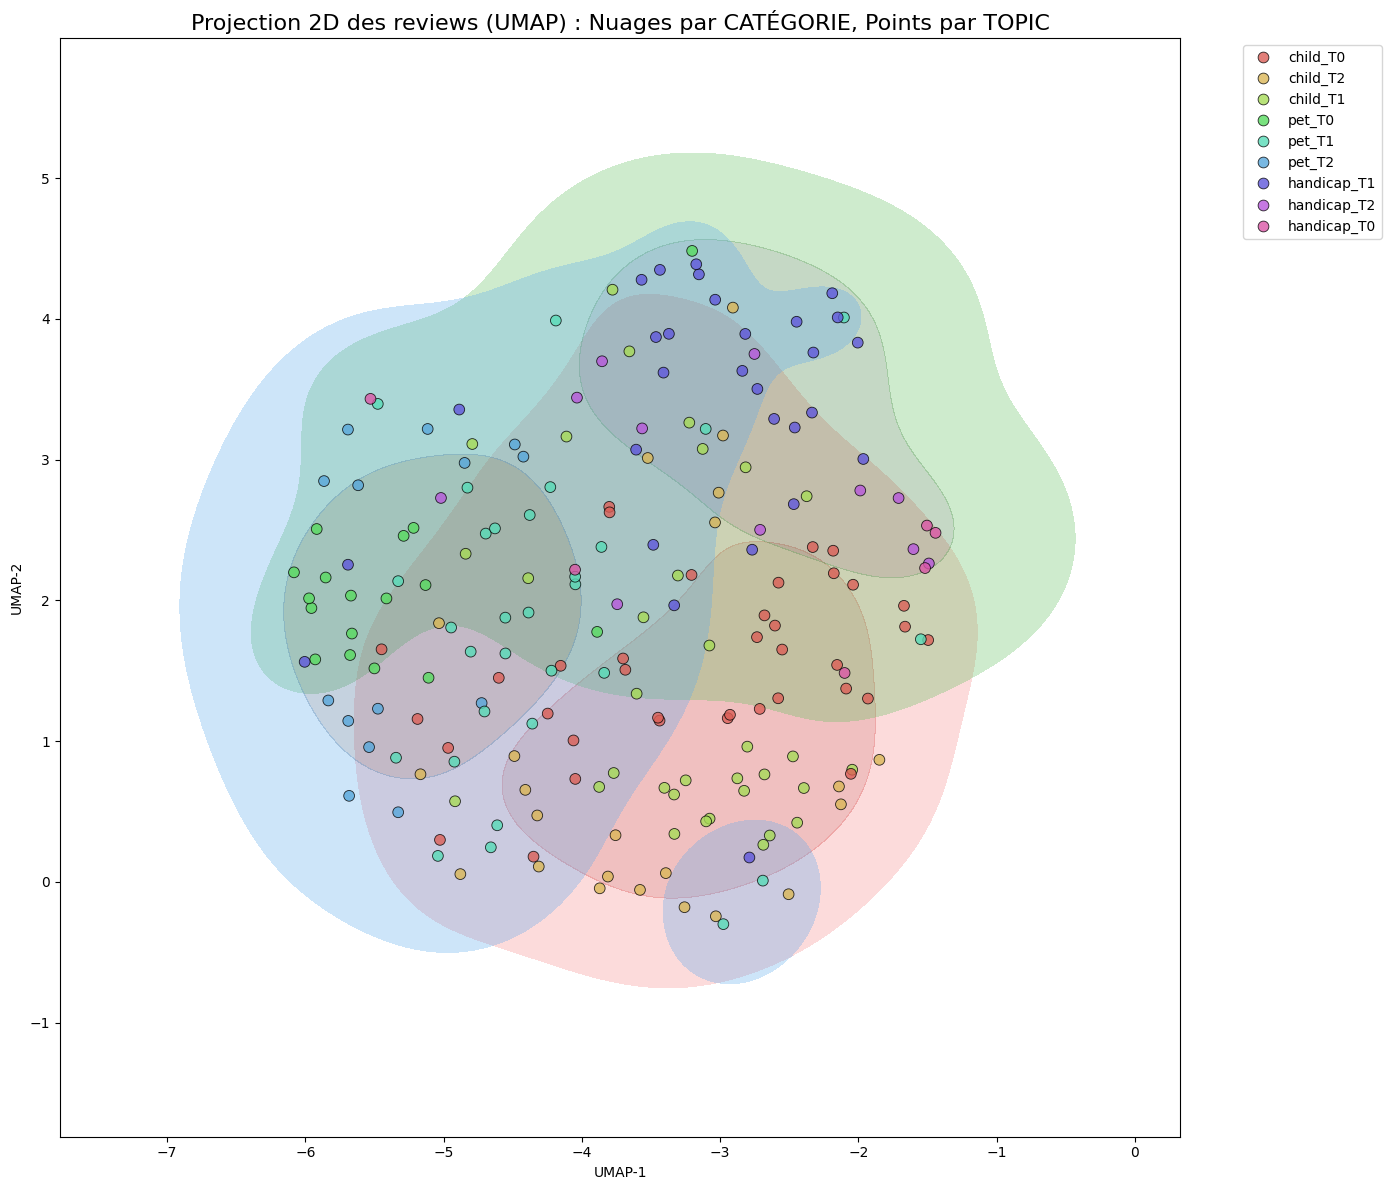

In [74]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# ============================================
# CONFIGURATION
# ============================================
n_topics = 3 
categories = df["category"].unique().to_list()

# TF-IDF global pour toutes les reviews
all_reviews = df["review_lemmatized"].to_list()
# vectorizer_global = TfidfVectorizer(
#     max_df=0.95,
#     min_df=1,
#     stop_words="english"
# )
X_global = vectorizer.fit_transform(all_reviews)
global_feature_names = vectorizer.get_feature_names_out()

# Array pour stocker le topic dominant de chaque review
dominant_topics_per_review = np.zeros(len(df), dtype=int)

# ============================================
# NMF PAR CATÉGORIE + attribution topic dominant
# ============================================
for cat in categories:
    # 1. Ajouter l'index global et filtrer
    df_cat_with_index = df.with_row_count("global_index").filter(pl.col("category") == cat)
    
    reviews_cat = df_cat_with_index["review_lemmatized"].to_list()
    
    if len(reviews_cat) < n_topics:
        n_topics_cat = max(1, len(reviews_cat))
    else:
        n_topics_cat = n_topics
        
    if n_topics_cat == 0:
        continue

    # Récupérer l'index global pour cette catégorie
    idxs_cat = df_cat_with_index["global_index"].to_numpy().flatten()
    
    # Transformer avec TF-IDF global
    X_cat_global = vectorizer.transform(reviews_cat)

    # NMF
    nmf_model = NMF(
        n_components=n_topics_cat,
        random_state=0,
        init='random',
        max_iter=500 
    ).fit(X_cat_global)

    # Calculer la distribution Doc-Topic et trouver le topic dominant
    doc_topic_dist = nmf_model.transform(X_cat_global)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    # ASSIGNATION ROBUSTE
    dominant_topics_per_review[idxs_cat] = dominant_topics
    
# Ajouter la colonne topic dominant
df = df.with_columns([pl.Series("dominant_topic", dominant_topics_per_review)])

# ============================================
# Créer colonne combinée category × topic
# ============================================
df = df.with_columns([
    (pl.col("category") + "_T" + pl.col("dominant_topic").cast(pl.Utf8)).alias("cat_topic")
])

# ============================================
# UMAP sur toutes les reviews
# ============================================
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
X_reviews_embedded = reducer.fit_transform(X_global) 

df_reviews_embedded = pd.DataFrame({
    "x": X_reviews_embedded[:,0],
    "y": X_reviews_embedded[:,1],
    "cat_topic": df["cat_topic"].to_list(),
    "category": df["category"].to_list() # Ajout de la colonne 'category' pour les nuages
})

# ============================================
# 🎨 VISUALISATION PAR CATÉGORIE AVEC CONTOURS DE DENSITÉ (KDE) 🎨
# ============================================
plt.figure(figsize=(14,12))

# 1. Préparation de la palette de couleurs
# La palette doit avoir suffisamment de couleurs pour TOUS les cat_topics
unique_cat_topics = df_reviews_embedded["cat_topic"].unique()
palette_colors = sns.color_palette("hls", n_colors=len(unique_cat_topics))
color_map = dict(zip(unique_cat_topics, palette_colors))

# Nous créons une palette séparée pour les nuages de CATÉGORIE (moins de couleurs)
unique_categories = df_reviews_embedded["category"].unique()
# Nous utilisons 'tab10' ou 'Set1' pour un contraste maximal entre les catégories
category_colors = sns.color_palette("Set1", n_colors=len(unique_categories))
category_color_map = dict(zip(unique_categories, category_colors))


# --- Ajout des Contours de Densité (KDE) basés sur la colonne 'category' ---
for cat_name, cat_data in df_reviews_embedded.groupby('category'): # Grouper par CATEGORY
    sns.kdeplot(
        data=cat_data,
        x="x",
        y="y",
        color=category_color_map[cat_name], # Utiliser la couleur de la catégorie
        levels=3, # Augmenter les niveaux donne un aspect plus 'nuage'
        linewidths=0, # Pas de ligne de contour
        alpha=0.3,
        # Remplissage de la zone
        fill=True,
        thresh=0.09, # Réduire le seuil pour englober plus de points (nuage plus grand)
        zorder=1
    )

# 2. Ajout des Points (Scatterplot) colorés par 'cat_topic'
# C'est important : les points montrent les topics (cat_topic), le nuage montre la catégorie (category)
sns.scatterplot(
    data=df_reviews_embedded,
    x="x",
    y="y",
    hue="cat_topic", # Couleur = Topic (l'info détaillée)
    palette=color_map, 
     
    alpha=0.8,
    s=60,
    edgecolor="k",
    zorder=2
)

plt.title("Projection 2D des reviews (UMAP) : Nuages par CATÉGORIE, Points par TOPIC", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()